# **0.0 Imports**

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import sweetviz as sv
from sklearn import preprocessing as pp
from sklearn import decomposition as dd
import plotly.express as px
from sklearn.manifold import TSNE
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn import cluster as c
from sklearn.metrics import silhouette_score
from sklearn import mixture as mx
import umap.umap_ as umap
from sklearn import manifold as mn
from sklearn import ensemble as en

## **0.1 Helper Functions**

In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [16, 9]
    plt.rcParams['font.size'] = 24
    
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## **0.2 Load Dataset**

In [3]:
data_raw = pd.read_csv('../data/raw/Ecommerce.csv', sep=',', decimal='.', encoding = 'ISO-8859-1' )
data_raw = data_raw.drop(columns = ['Unnamed: 8'])
df1 = data_raw.copy()

# **1.0 Descrição dos dados**

## 1.1 Rename Columns

In [4]:
cols_new = ['invoice_no', 'stock_code',
            'description', 'quantity', 'invoice_date', 
            'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2 Data Dimensions

In [5]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 541909
Number of columns: 8


## 1.3 Data types

In [6]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [7]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [8]:
#substituir os NA
df_missing = df1.loc[df1['customer_id'].isna(), :] #pegou o df1 onde existem os NA e colocou em todas as colunas
df_not_missing = df1.loc[~df1['customer_id'].isna(), :] #pegou o df1 onde nao tem os na e colocou em todas as col

In [9]:
#rsubstituir os NA

#primeiro será na coluna customer_id [naoo tem 135082 registros]

df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates()) #removendo as duplicadas do invoice
df_backup['customer_id'] = np.arange(1900, 1900+len(df_backup),1) #pegou do df que tem NA e aplicou 1900 + o tamanho


#unindo o original com o df de referencia
df1 = pd.merge(df1, df_backup, on = 'invoice_no', how = 'left')

#coalesce

df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y']) #combinou. Se tem em uma e nao tem na outra ela cola

#apagar colunas extras

df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis = 1)

df1.head()


#depois do 19000 eu criei artificialmente

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.00
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.00


In [10]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6 Change types

In [11]:
df1['invoice_date'] =  pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')
df1['customer_id'] = df1['customer_id'].astype(int)
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


## 1.7 Descriptive Analysis

In [12]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Atributes

In [13]:
# Central tendency - mean, median
#mean
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
#median
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - desvio, minimo, maximo, range, skew, kutosi

d1 = pd.DataFrame(num_attributes.apply(np.std)).T

d2 = pd.DataFrame(num_attributes.apply(np.min)).T

d3 = pd.DataFrame(num_attributes.apply(np.max)).T

d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T

d5 = pd.DataFrame(num_attributes.apply(lambda x : x.skew())).T

d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concat 
h = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
h.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'] 


h

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.00,161990.00,9.55,3.00,218.08,-0.26,119769.16
1,unit_price,-11062.06,38970.00,50032.06,4.61,2.08,96.76,186.51,59005.72


### 1.7.2 Categorical Attributes

In [14]:
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]

In [15]:
print('total invoices with letter: {}'.format(len(df_letter_invoices)))
print('total quantity with negative value:  {}'.format(len(df_letter_invoices[df_letter_invoices['quantity'] < 0 ])))

total invoices with letter: 9291
total quantity with negative value:  9288


## **Stock Code**

In [16]:
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [17]:
df1['country'].value_counts(normalize = True).head()

United Kingdom   0.91
Germany          0.02
France           0.02
EIRE             0.02
Spain            0.00
Name: country, dtype: float64

In [18]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending = False).head() 

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# **2.0 Filter Variables**

In [19]:
df2 = df1.copy()

In [20]:
# === Numerical attributes ====
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# === Categorical attributes ====
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ) ]

# description
df2 = df2.drop( columns='description', axis=1 )

# map -  
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]

# bad users
df2 = df2[~df2['customer_id'].isin( [16446] )]

# quantity
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

# **3.0 Feature Engineering**

In [21]:
df3 = df2.copy()

## **3.1 Feature Creation**

In [22]:
# data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates( ignore_index=True )

### 3.1.1 Gross Revenue

In [23]:
 # Gross Revenue ( Faturamento ) quantity * price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

c:\Users\victo\Music\Projetos\insiders_clustering\venv\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


customer_id       0
gross_revenue    91
dtype: int64

### **3.1.2 Recency**

In [24]:
 # Recency - Last day purchase
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### **3.1.3 Quantity of purchased**

In [25]:
df_freq = (df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates()
                                                             .groupby( 'customer_id' )
                                                             .count()
                                                             .reset_index()
                                                             .rename( columns={'invoice_no': 'qtde_invoices'}) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
dtype: int64


### **3.1.4 Quantity total of items purchased**m

In [26]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'quantity']].groupby( 'customer_id' ).sum()
                                                           .reset_index()
                                                           .rename( columns={'quantity': 'qtde_items'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
dtype: int64


### **3.1.5 Quantity of items purchased**

In [27]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                           .reset_index()
                                                           .rename( columns={'stock_code': 'qtde_products'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
dtype: int64

### **3.1.6 Avg Ticket Value**

In [28]:
# Avg Ticket
df_avg_ticket = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
avg_ticket       91
dtype: int64

### **3.1.6 Average Recency Days**

In [29]:
# Average recency days
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=['False', 'False'] )
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date

df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()

# average recency 
df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

# merge
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
dtype: int64

### **3.1.7 Frequency Purchase**

In [30]:
df_aux = ( df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()
# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64

### **3.1.8 Number of Returns**

In [31]:
 # Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
dtype: int64

### **3.1.9 Basket Size - Quantidade de Items por cesta**

In [32]:
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                  n_products=( 'quantity', 'sum' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
avg_basket_size       91
dtype: int64

### **3.1.10 Unique Basket Size - Quantidade de produtos distintos por cesta**

In [33]:
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                   n_products=( 'stock_code', 'nunique' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_items                  91
qtde_products               91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

# **4.0 Exploratory Data Analysis (EDA)**

In [34]:
df4 = df_ref.dropna()

## 4.1 Univariate Analysis

In [35]:
#report = sv.analyze(df4)
#report.show_html('analyze.html', open_browser=True)


## **4.2 Bivariate Analysis**

In [36]:
cols = ['customer_id']
df42 = df4.drop(cols, axis = 1)

<Figure size 1800x864 with 0 Axes>

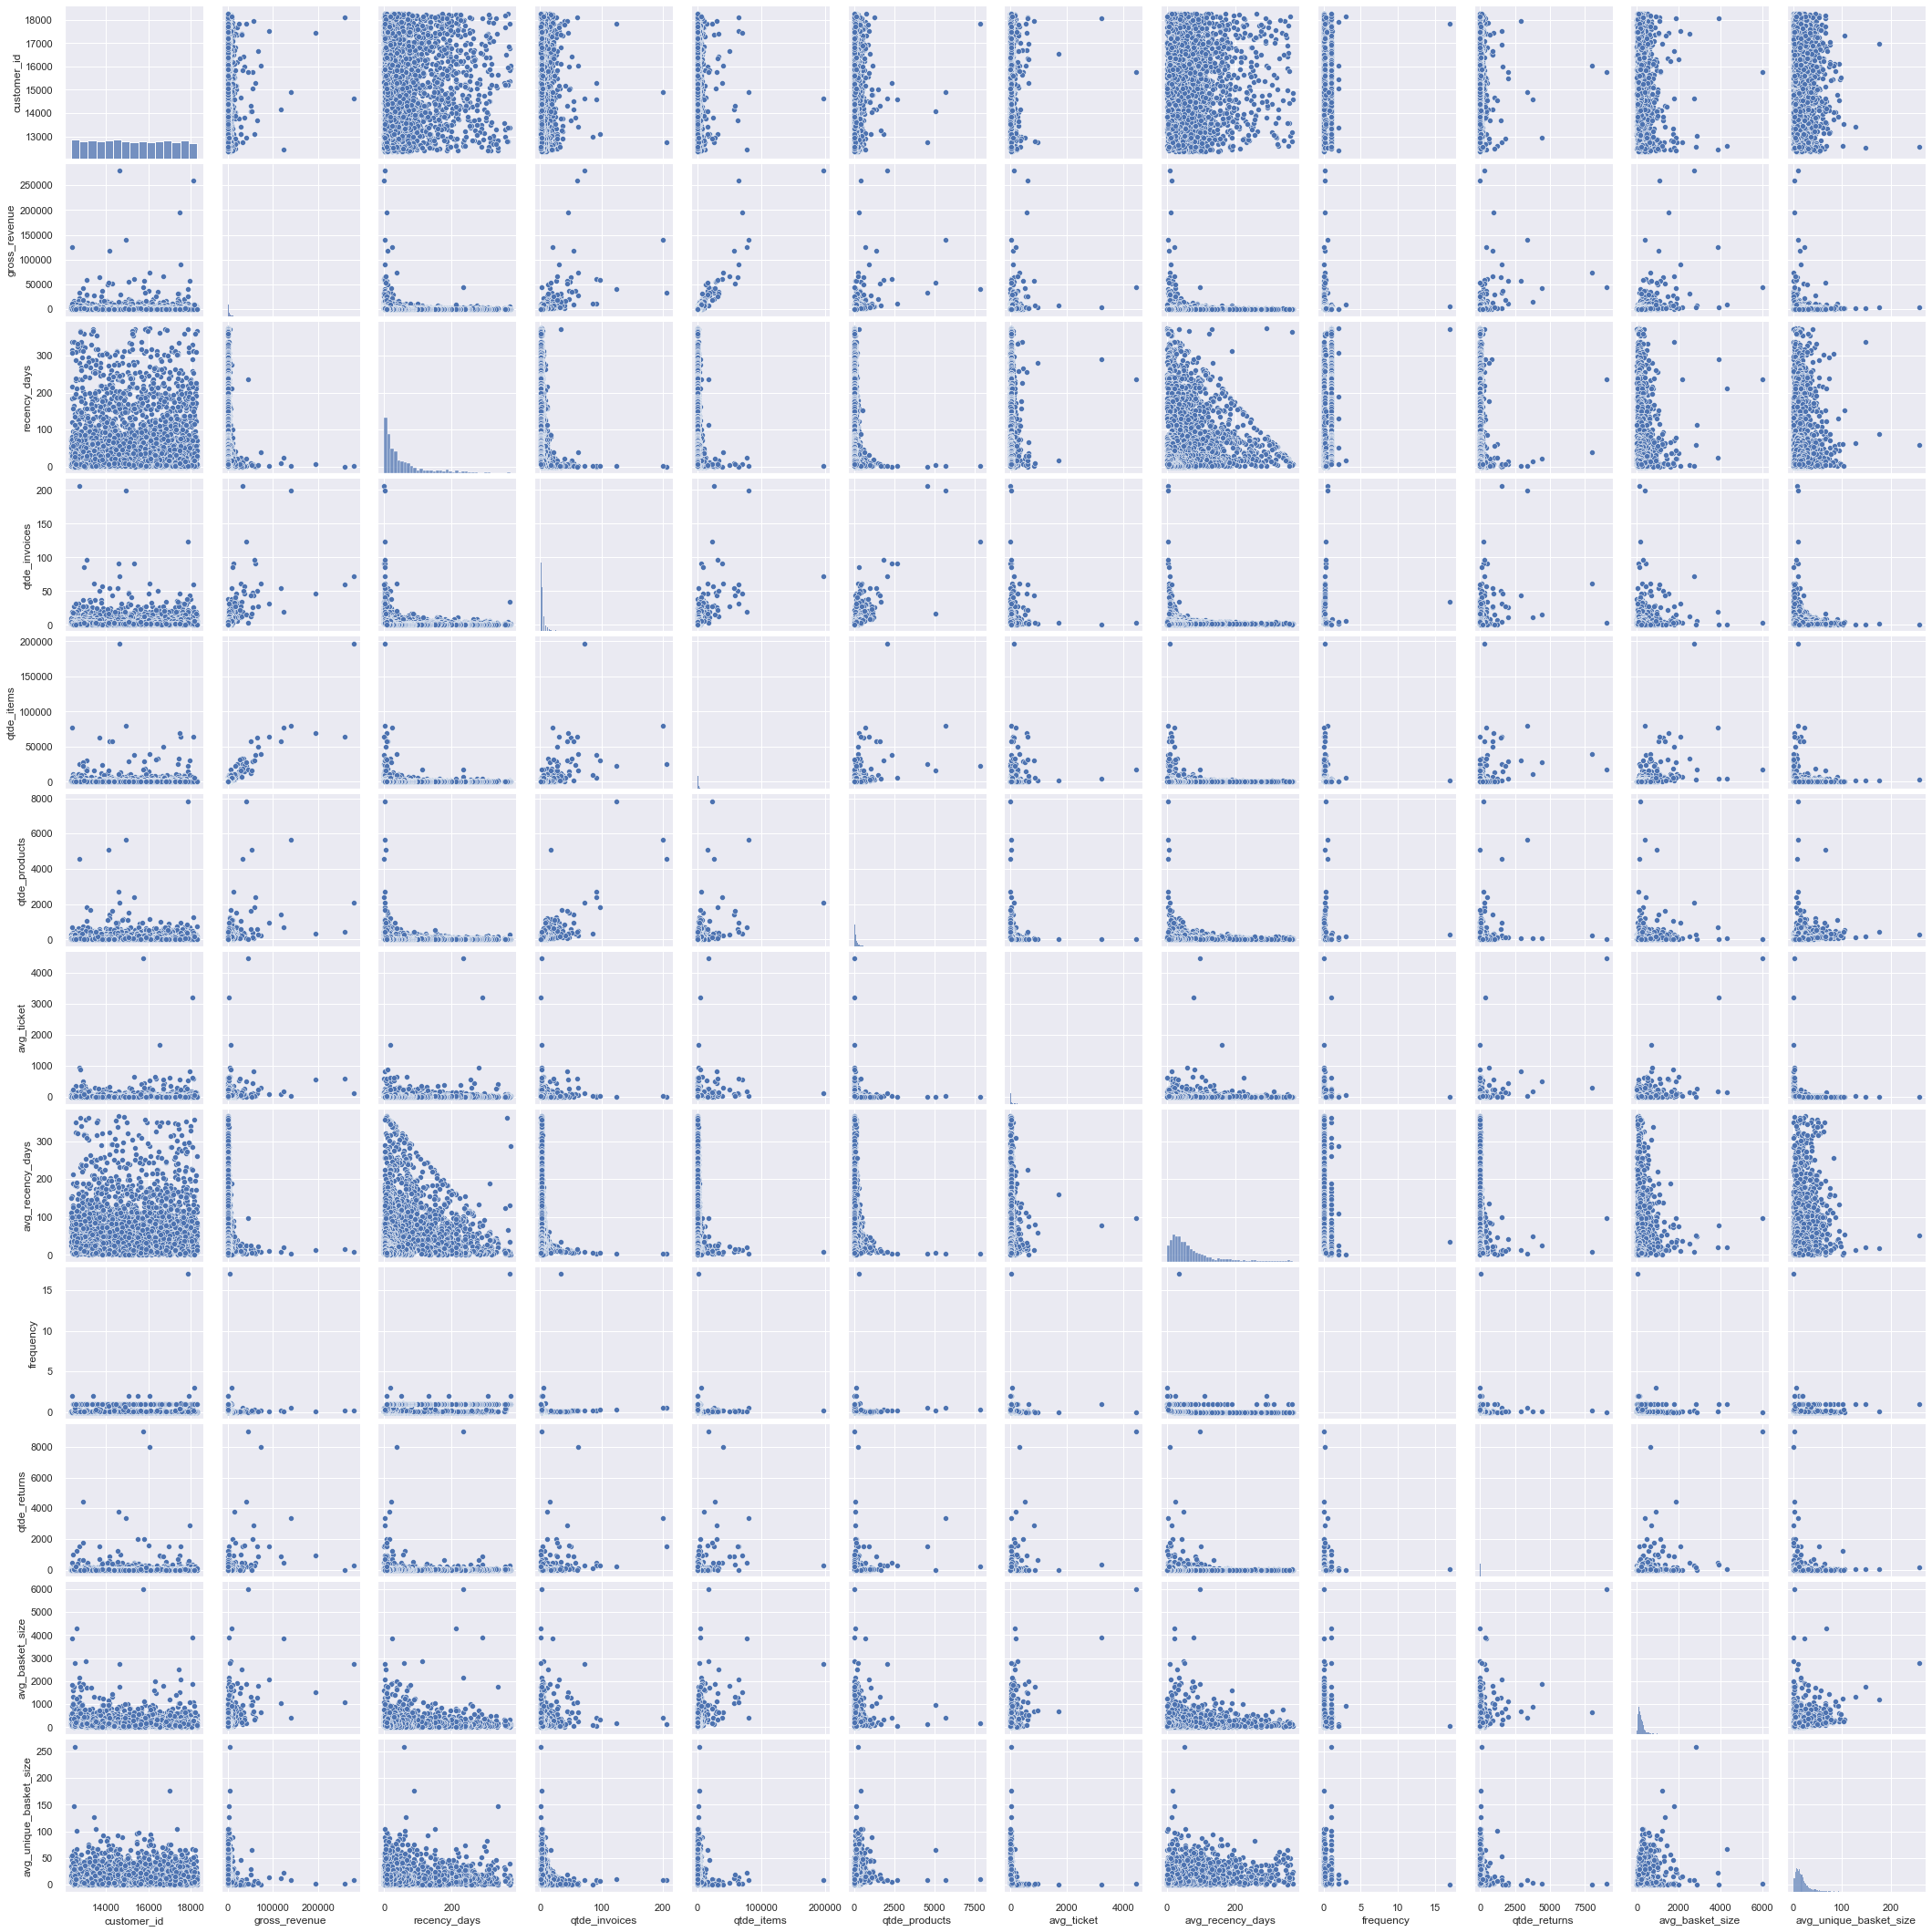

In [37]:
plt.figure(figsize = (25,12));
sns.pairplot(df4);

*Note*: **Frequency and avg ticket both doesn't have so much variation, so is a strong candidate to drop down**

## **4.3 Space Study**

In [38]:
df4.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.00,34.00,1733.00,297.00,18.15,35.50,17.00,40.00,50.97,0.62
1,13047,3232.59,56.00,9.00,1390.00,171.00,18.90,27.25,0.03,35.00,154.44,11.67
2,12583,6705.38,2.00,15.00,5028.00,232.00,28.90,23.19,0.04,50.00,335.20,7.60
3,13748,948.25,95.00,5.00,439.00,28.00,33.87,92.67,0.02,0.00,87.80,4.80
4,15100,876.00,333.00,3.00,80.00,3.00,292.00,8.60,0.07,22.00,26.67,0.33


In [39]:
# original dataset
#df43 = df4.drop( columns=['customer_id'], axis=1 ).copy()

# selected dataset
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']
df43 = df4[ cols_selected ].copy() 

### **4.3.1 Min Max Scaler**

In [40]:
mm = pp.MinMaxScaler()
# 

df43['gross_revenue'] = mm.fit_transform( df43[['gross_revenue']] )
df43['recency_days']           = mm.fit_transform( df43[['recency_days']] )
#df43['qtde_invoices']          = mm.fit_transform( df43[['qtde_invoices']])
#df43['qtde_items']             = mm.fit_transform( df43[['qtde_items']])
df43['qtde_products']          = mm.fit_transform( df43[['qtde_products']])
#df43['avg_ticket']             = mm.fit_transform( df43[['avg_ticket']])
#df43['avg_recency_days']       = mm.fit_transform( df43[['avg_recency_days']])
df43['frequency']              = mm.fit_transform( df43[['frequency']])
df43['qtde_returns']           = mm.fit_transform( df43[['qtde_returns']])
#df43['avg_basket_size']        = mm.fit_transform( df43[['avg_basket_size']])
#df43['avg_unique_basket_size'] = mm.fit_transform( df43[['avg_unique_basket_size']] )


X = df43.copy()

In [41]:
X.shape

(2968, 6)

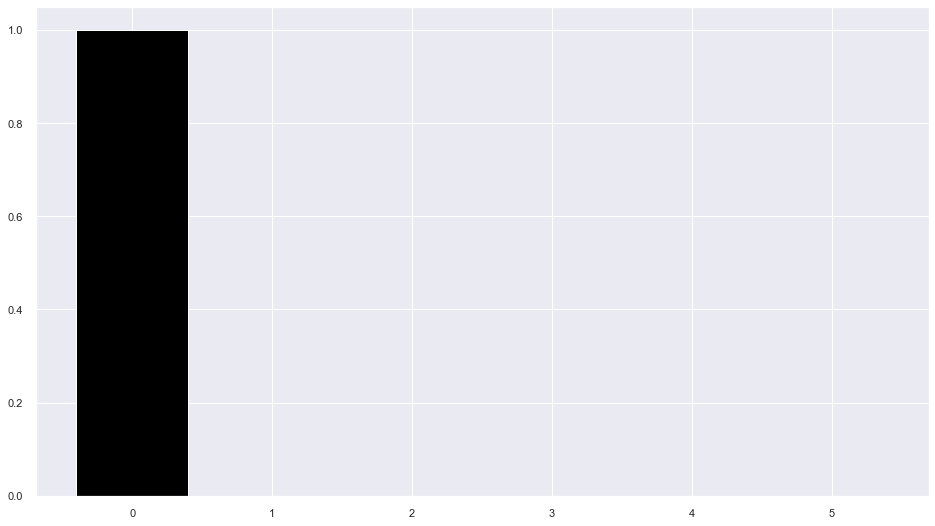

In [42]:
pca = dd.PCA(n_components = X.shape[1])
principal_components = pca.fit_transform(X)
features = range( pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color = 'black')

df_pca = pd.DataFrame(principal_components)

In [43]:
#for future tests 
#https://plotly.com/python/pca-visualization/#visualize-all-the-principal-components

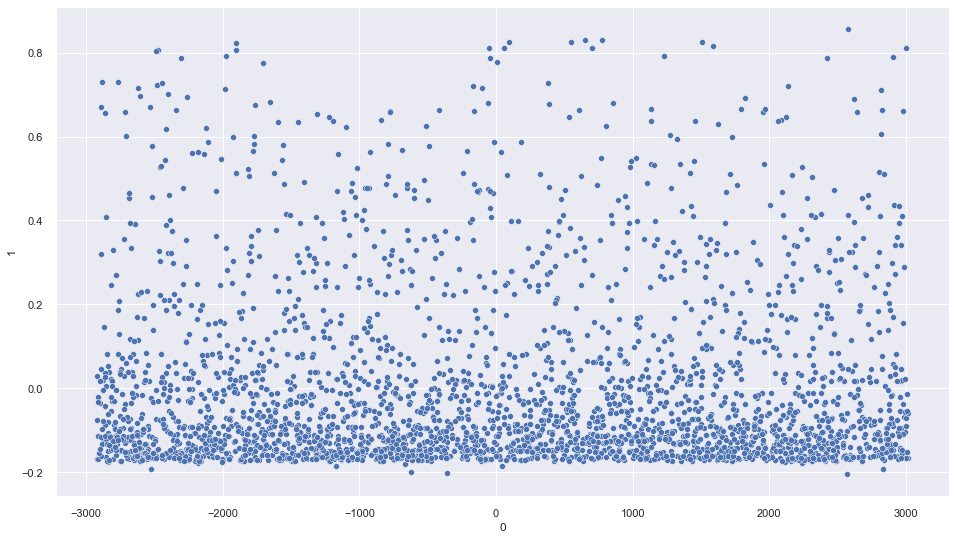

In [44]:
sns.scatterplot(x = 0, y = 1, data = df_pca);

### **4.4.1 T-SNE**

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

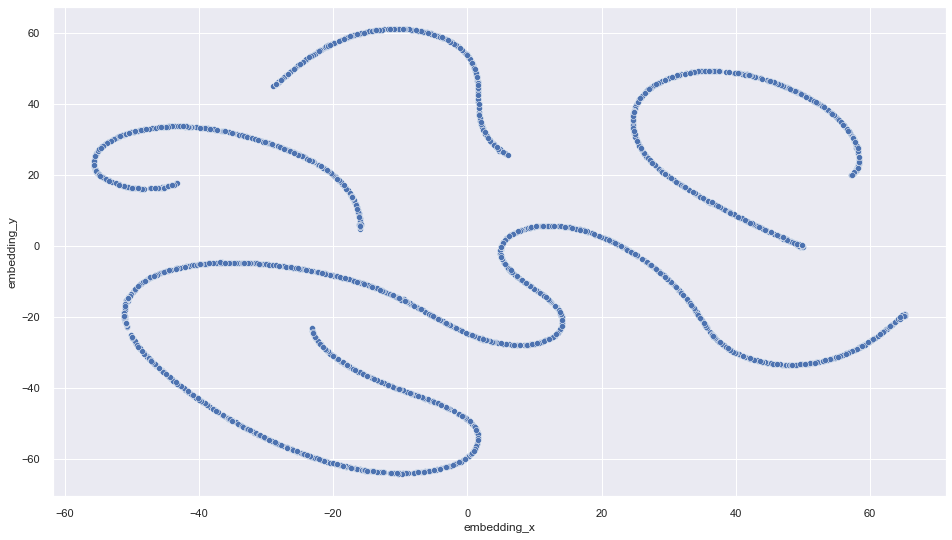

In [45]:
reducer = mn.TSNE( n_components=2, n_jobs=-1, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_pca )

### **4.4.1 Tree-Based Embedding**

In [49]:
# training dataset
X = df43.drop( columns=['customer_id', 'gross_revenue'], axis=1 )
y = df43['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model training
rf_model.fit( X, y )

# Leaf 

# dataframe Leaf

RandomForestRegressor(random_state=42)

In [50]:
 df_leaf = pd.DataFrame( rf_model.apply( X ) )

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

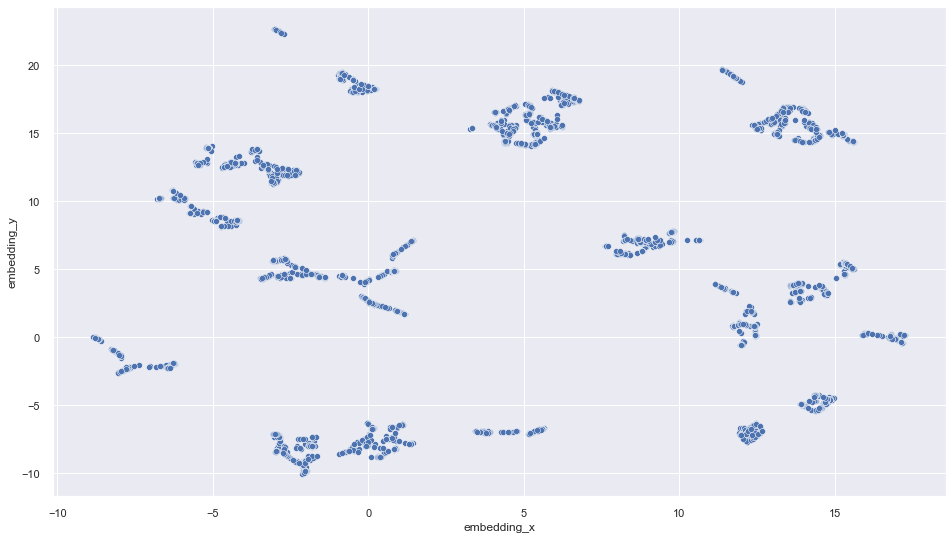

In [51]:
# Reduzer dimensionality
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_tree )

# **5.0 Data Preparation**

In [52]:
df5 = df_tree.copy()
df5.head()

,embedding_x,embedding_y
0,-0.41,-8.28
1,-7.74,-2.29
2,0.55,-8.55
3,8.92,6.58
4,14.24,2.88


In [53]:
#ss = pp.MinMaxScaler()#

#df5['gross_revenue'] = ss.fit_transform(df5[['gross_revenue']])
#df5['recency_days'] = ss.fit_transform(df5[['recency_days']])
#df5['qtd_invoices'] = ss.fit_transform(df5[['qtd_invoices']])
#df5['qtd_items'] = ss.fit_transform(df5[['qtd_items']])
#df5['qtd_products'] = ss.fit_transform(df5[['qtd_products']])
#df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])
#df5['avg_recency_days'] = ss.fit_transform(df5[['avg_recency_days']])
#df5['frequency'] = ss.fit_transform(df5[['frequency']])
#df5['qtd_returns'] = ss.fit_transform(df5[['qtd_returns']])
#df5['avg_basket_size'] = ss.fit_transform(df5[['avg_basket_size']])
#df5['avg_unique_basket_size'] = ss.fit_transform(df5[['avg_unique_basket_size']])

# **6.0 Feature Selection**

In [54]:
df6 = df_tree.copy()

# **7.0 Hyperparameter Fine-Tunning**

In [55]:
X = df_tree.copy()

In [56]:
clusters = np.arange( 2, 25, 1)
clusters

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24])

## **7.1 KMeans**

In [57]:
from sklearn import metrics as m

In [58]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans( n_clusters=k )

    # model training
    kmeans_model.fit( X )

    # model predict
    labels = kmeans_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )

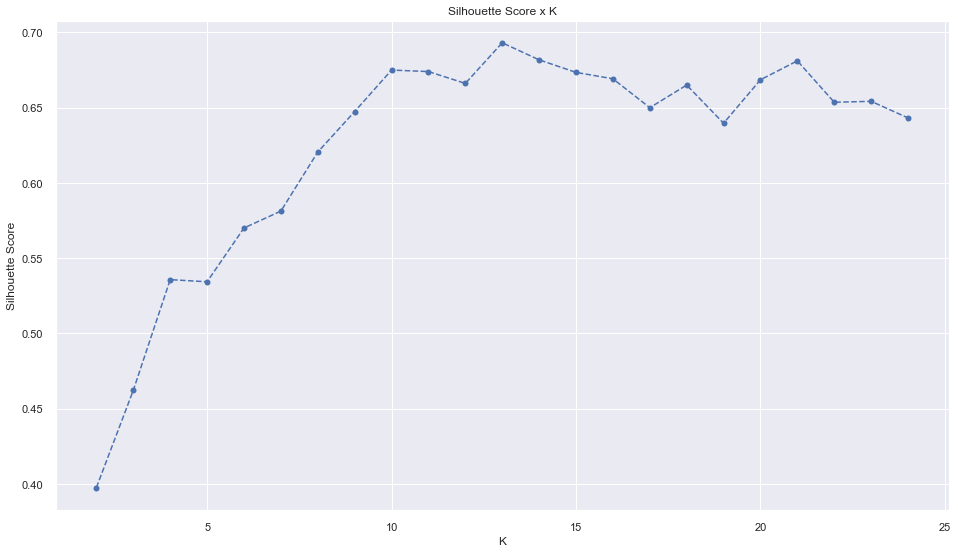

In [59]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K' );

## 7.2 GMM

In [60]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture( n_components=k )

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )

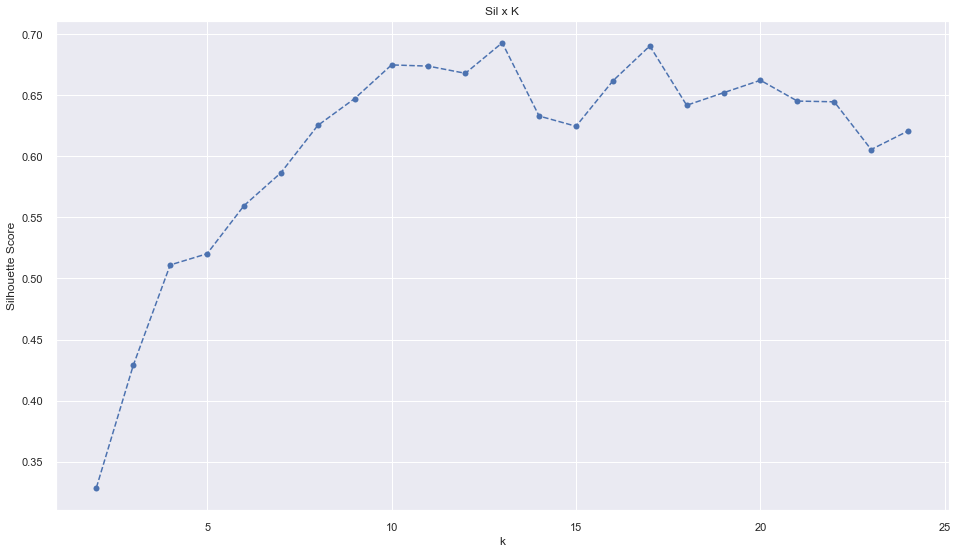

In [61]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score');
plt.title( 'Sil x K');

## **7.3. Hierarchical Clustering**

In [62]:
from scipy.cluster import hierarchy as hc

In [63]:
 # model definition and training
hc_model = hc.linkage( X, 'ward' )

In [64]:
#hc.dendrogram( 
#    hc_model, 
#    leaf_rotation=90,
#    leaf_font_size=8
#)
#
#plt.plot()

In [65]:
#hc.dendrogram( 
#    hc_model,
#    truncate_mode='lastp',
#    p=12,
#    leaf_rotation=90,
#    leaf_font_size=8,
#    show_contracted=True
#)
#
#plt.show()

## 7.3.1. HClustering Silhouette Score

In [66]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

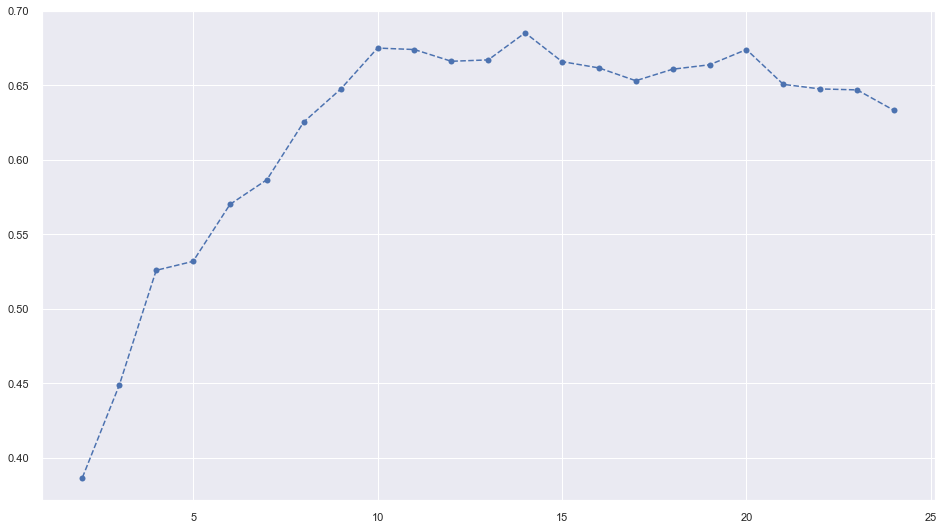

In [67]:
plt.plot( clusters,  hc_list, linestyle='--', marker='o', color='b' )

## 7.4. DBSCAN

In [68]:
eps=2.00
min_samples=20 

# model definition
dbscan_model = c.DBSCAN( eps=eps, min_samples=min_samples )

# mode training & predict 
labels = dbscan_model.fit_predict( X )

sil = m.silhouette_score( X, labels, metric='euclidean' )
print( 'Silhouette Score: {}'.format( sil ) )
print( 'Number of Clusters: {}'.format( len( unique( labels ) ) ) )
print( unique( labels ) )

Silhouette Score: 0.6613478064537048
Number of Clusters: 15
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [69]:
from sklearn.neighbors import NearestNeighbors

In [70]:
neighbors = NearestNeighbors( n_neighbors=min_samples ).fit( X )
distances, indices = neighbors.kneighbors( X )

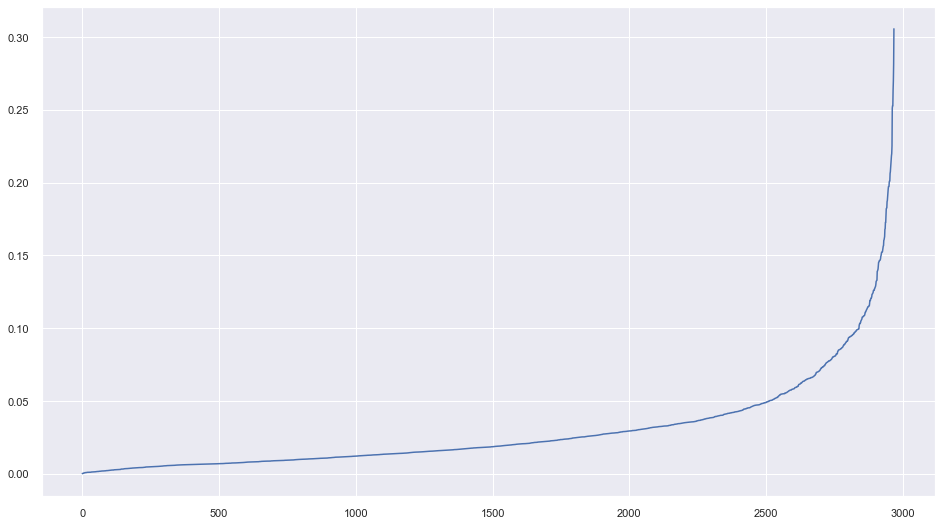

In [71]:
distances = np.sort( distances, axis=0 )
distances = distances[:,1]
plt.plot( distances )

In [72]:
dbscan_list = [ 0.622034, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000]

## 7.5 Results

In [73]:
 # Model Name | k=2 | k=3 | k=4 | k=5 | ...
#  Kmeans      SS    SS    SS    SS
#  GMM         SS    SS    SS    SS
#  HC         SS     SS    SS    SS
#  DBSCAN     SS    SS    SS    SS

df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list, 
     'HC': hc_list}
     #'DBSCAN': dbscan_list}
).T

df_results.columns = clusters

In [74]:
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.397599,0.462214,0.535710,0.534298,0.570022,0.581241,0.620464,0.647369,0.674931,0.673929,0.666059,0.693039,0.681719,0.673382,0.669141,0.649937,0.664956,0.639614,0.668492,0.681043,0.653541,0.654173,0.643124
GMM,0.328770,0.428953,0.511095,0.520268,0.559631,0.586557,0.625321,0.647369,0.674931,0.673929,0.668053,0.693039,0.633068,0.624678,0.661865,0.690465,0.641879,0.652154,0.662349,0.645304,0.644717,0.605641,0.620817
HC,0.386713,0.448766,0.525785,0.531805,0.570022,0.586557,0.625321,0.647369,0.674931,0.673929,0.666059,0.666984,0.685169,0.665831,0.661606,0.653005,0.660743,0.663708,0.673943,0.650557,0.647505,0.646851,0.633110


### **7.6 Sillhouete Analysis**

 For K = 2. Silhouette Score: 0.38671302795410156
 For K = 3. Silhouette Score: 0.4487655460834503
 For K = 4. Silhouette Score: 0.5257847905158997
 For K = 5. Silhouette Score: 0.5318048000335693
 For K = 6. Silhouette Score: 0.5700216889381409
 For K = 7. Silhouette Score: 0.5865572094917297


IndexError: index 3 is out of bounds for axis 0 with size 3

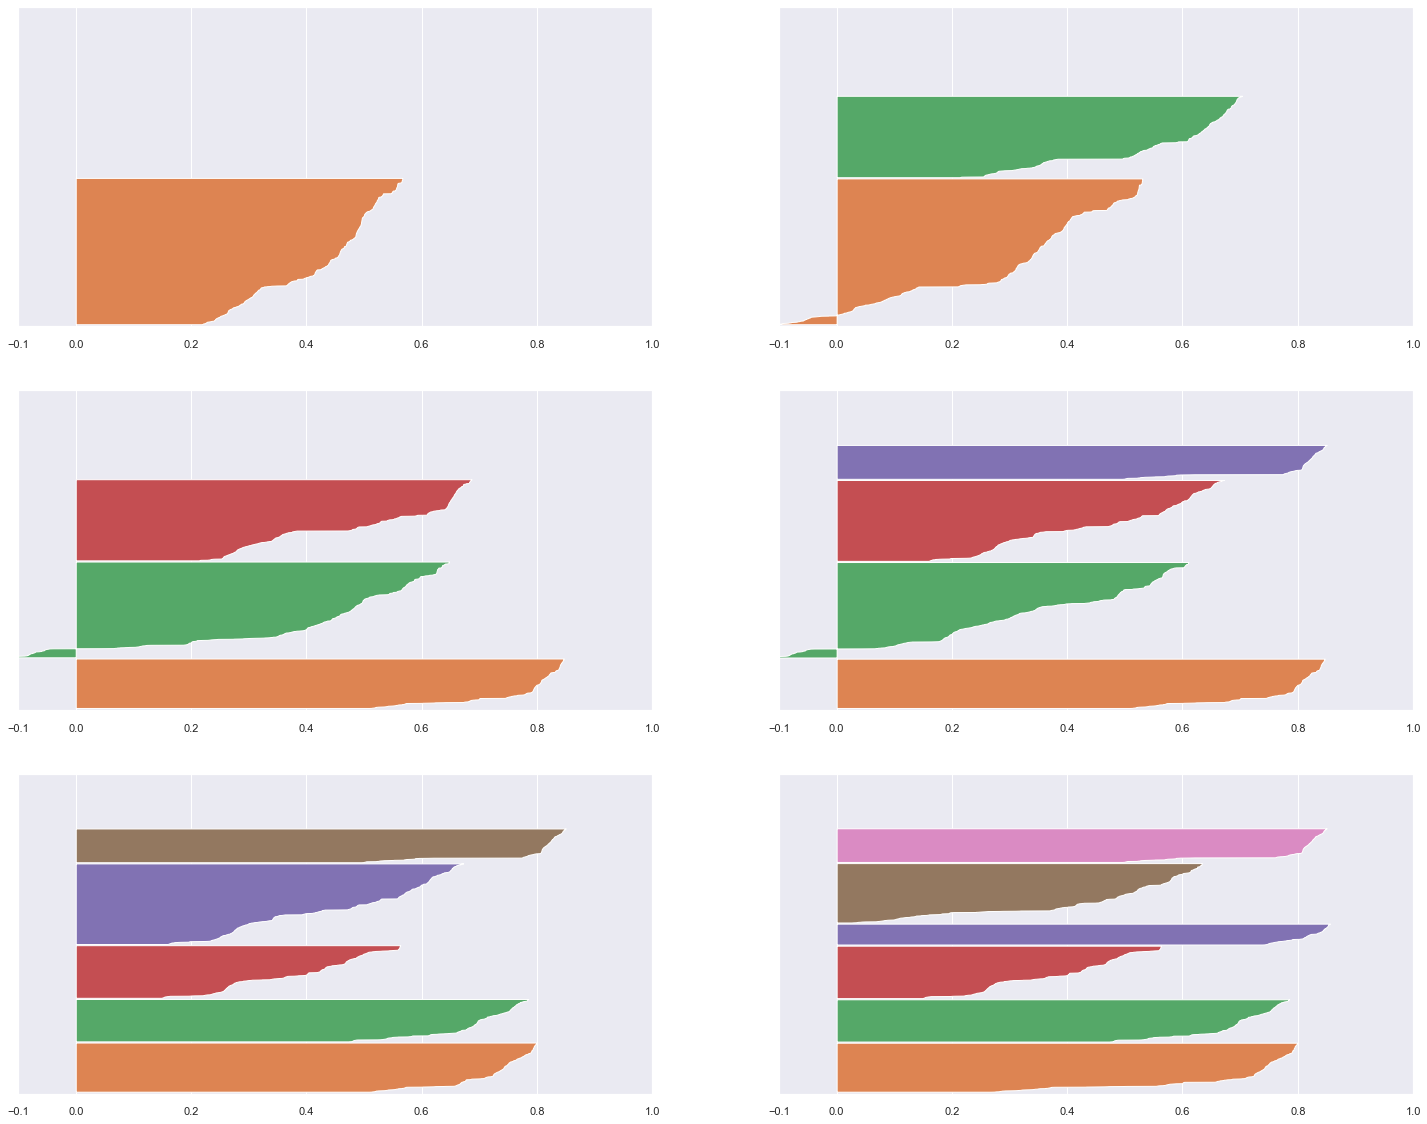

In [75]:
fig, ax = plt.subplots( 3, 2 )
fig.set_size_inches( 25, 20 )

for k in clusters:
    q, mod = divmod( k, 2 )
    
    ax[q-1, mod].set_xlim( [ -0.1, 1] )
    ax[q-1, mod].set_ylim( [ 0, len( X ) + ( k+1 )*10] )
    
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # performance
    ss = m.silhouette_score( X, labels, metric='euclidean' )
    print( ' For K = {}. Silhouette Score: {}'.format( k, ss ) )

    samples_silhouette_values = m.silhouette_samples( X, labels )

    y_lower = 10
    for i in range( k ):

        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[ labels == i]
        
        # sort values
        ith_samples_silhouette_values.sort()

        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap( 'Spectral' )
        color = cmap( i / k )

        ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ), 0, ith_samples_silhouette_values  )
        
        y_lower = y_upper + 10
        
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks( [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# **8.0 Model Training**

In [101]:
# model definition
k = 8
#kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300 )
#
## model training
#kmeans.fit( X )
#
## clustering
#labels = kmeans.labels_

In [119]:
## model definition
gmm_model = mx.GaussianMixture( n_components=k, random_state=42)

# model training
gmm_model.fit( X )

# model predict
labels = gmm_model.predict( X )

## 8.2. Cluster Validation

In [120]:
## WSS ( Within-cluster sum of square)
#print( 'WSS value: {}'.format( kmeans.inertia_ ) )

## SS ( Silhouette Score )
print( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

SS value: 0.6253213882446289


# **9.0 Cluster Analysis**

In [121]:
df9 = X.copy()
df9['cluster'] = labels

In [122]:
df9.head()

,embedding_x,embedding_y,cluster
0,-0.41,-8.28,3
1,-7.74,-2.29,6
2,0.55,-8.55,3
3,8.92,6.58,4
4,14.24,2.88,4


## 9.1 Validation Inspection

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

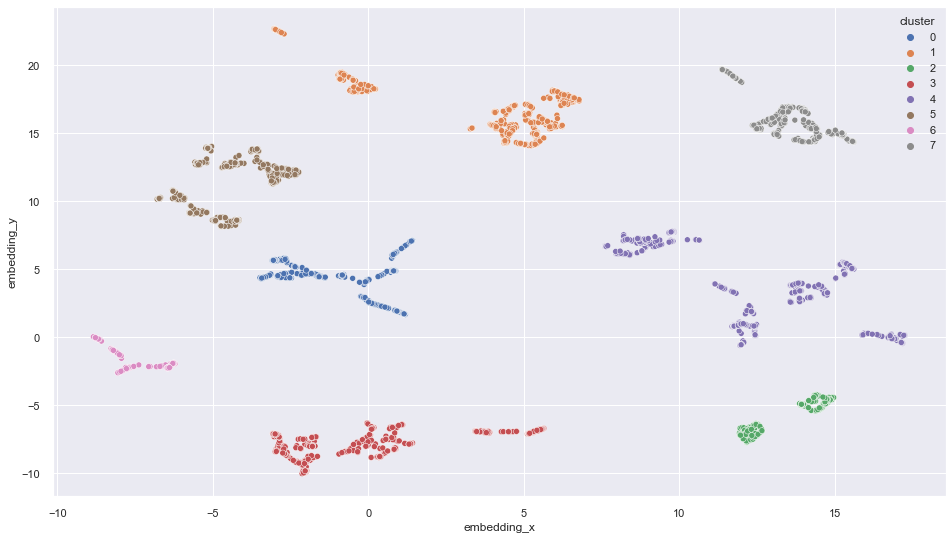

In [123]:
sns.scatterplot( x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep')

## **9.2 Visualization Inspector - 2dplot**

In [124]:
#df_viz = df9.copy()
#sns.pairplot( df_viz, hue = 'cluster');

## **9.2 Visualization Inspector - UMAP - t-sne**

## 9.2 Cluster Profile

In [125]:
df92 = df4[ cols_selected ].copy()
df92['cluster'] = labels
df92.head() 

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.21,372.00,297.00,17.00,40.00,3
1,13047,3232.59,56.00,171.00,0.03,35.00,6
2,12583,6705.38,2.00,232.00,0.04,50.00,3
3,13748,948.25,95.00,28.00,0.02,0.00,4
4,15100,876.00,333.00,3.00,0.07,22.00,4


In [126]:
# Number of customer
df_cluster = df92[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df92[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg invoice_no
df_qtde_products = df92[['qtde_products', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_products, how='inner', on='cluster' )

# Frequency
df_frequency = df92[['frequency', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_frequency, how='inner', on='cluster' )

# Returns
df_qtde_returns = df92[['qtde_returns', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_returns, how='inner', on='cluster' )

df_cluster.sort_values('gross_revenue', ascending = False)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
3,3,468,15.77,8836.14,21.44,424.13,0.09,149.27
6,6,145,4.89,3164.25,34.43,173.88,0.06,23.48
0,0,356,11.99,2404.84,43.60,128.37,0.04,19.90
1,1,506,17.05,2127.02,58.88,66.75,0.05,16.89
5,5,404,13.61,1689.18,54.80,89.20,0.05,11.54
7,7,322,10.85,971.03,75.33,37.46,0.07,6.57
2,2,200,6.74,647.93,47.28,11.51,0.03,0.84
4,4,567,19.10,605.03,131.71,19.01,0.34,13.59


In [ ]:
#3 - Insiders
#6
#0
#1
#5
#7
#2
#4
#
#


## Cluster 01 (Candidato à insiders)

- Número de customers: 468 (16% do customers )
- Faturamento médio: 8836
- Recência média: 21 dias
- Média de Produtos comprados: 424 produtos
- Frequência de Produtos comprados: 0.09 produtos/dia
- Receita em média: $8836.13,00 dólares

## Cluster 02 

- Número de customers: 31 (0.71 do customers )
- Recência em média: 14 dias
- Compras em média: 53 compras
- Receita em média: $40.543,52 dólares

## Cluster 03

- Número de customers: 4.335 (99% do customers )
- Recência em média: 92 dias
- Compras em média: 5 compras
- Receita em média: $1.372,57 dólares


# **10.0 Análise Exploratória de Dados dos Clusters**

In [85]:
df10 = df92.copy()

In [86]:
df_cluster.sort_values(by = 'gross_revenue', ascending= False)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
2,2,468,15.77,8836.14,21.44,424.13,0.09,149.27
6,6,130,4.38,4689.93,47.41,103.90,0.06,20.75
7,7,501,16.88,2624.63,40.95,141.54,0.05,20.94
3,3,404,13.61,1689.18,54.80,89.20,0.05,11.54
1,1,376,12.67,1240.91,62.84,53.90,0.05,15.56
4,4,322,10.85,971.03,75.33,37.46,0.07,6.57
0,0,200,6.74,647.93,47.28,11.51,0.03,0.84
5,5,567,19.10,605.03,131.71,19.01,0.34,13.59


In [87]:
#Clusters insiders 2

## 10.1. MindMap de hipoteses

### 10.1.1 Hipóteses de Compra

**H1. Os clientes do cluster insiders possuem um volume (produtos) de compras acima de 10% do total de compras**

**H2. Os clientes do cluster insiders possuem um volume (faturamento) de compras acima de 10% do total de compras**

**H3. Os clientes do cluster insiders tem um número de devolução abaixo da média da base total de clientes**

**H4. A média de faturamento dos clusters insiders é 10% maior do que a mediana do faturamento total**



**H1. Os clientes do cluster insiders possuem um volume (produtos) de compras acima de 10% do total de compras**


*Verdadeiro. Os clusters insiders possuem um volume de compra de 54.48%

In [127]:
# soma da qtde de produtos do insiders
df_sales_insiders = df10.loc[df10['cluster'] == 2, 'qtde_products'].sum()
df_sales_total = df10.loc[:, 'qtde_products'].sum()

# soma da qtde de produtos total
print( '% Sales Insiders: {:.2f}%'.format( 100*df_sales_insiders / df_sales_total ) )

% Sales Insiders: 54.48%


**H2. Os clientes do cluster insiders possuem um volume (faturamento) de compras acima de 10% do total de compras**

*Verdadeiro. Os clusters insiders possuem GMV de 51.73%*

In [128]:
df_gmv_insiders = df10.loc[df10['cluster'] == 2, 'gross_revenue'].sum()
df_gmv_total = df10.loc[:, 'gross_revenue'].sum()

print('% GMV dos Insiders: {:.2f}%'.format(100*df_gmv_insiders/df_gmv_total))

% GMV dos Insiders: 51.73%


**H3. Os clientes do cluster insiders tem um número de devolução média abaixo da média da base total de clientes**



*Falso. O clusters insiders tem devoluções acima da média geral*

In [129]:
df_returns_insiders = df10.loc[df10['cluster'] == 2, 'qtde_returns'].mean()

df_returns_total = df10.loc[:, 'qtde_returns'].mean()

print(' Média de retornos dos insiders é: {:.2f}'.format(df_returns_insiders) + ' vs Média de retornos total: {:.2f}'.format(df_returns_total))

 Média de retornos dos insiders é: 149.27 vs Média de retornos total: 34.89


**H4. A média de faturamento dos clusters insiders é 10% maior do que a mediana do faturamento total**


In [91]:
#mediana do gmv dos insiders
df_insiders_gmv_median = df10.loc[df10['cluster'] == 2, 'gross_revenue'].median()
    
#mediana de gmv do total
df_total_gmv_median = df10.loc[:, 'gross_revenue'].median()


#Diferença
gmv_diff = (df_insiders_gmv_median - df_total_gmv_median)/ df_total_gmv_median
print('Mediana diff é: {:.2f}%'.format(100*gmv_diff))

Mediana diff é: 276.48%


**H5. O GMV dos clusters insiders está concentrada nos dois primeiros quartis (Consideração de que eles gastam pouco)**

*Verdadeiro*.

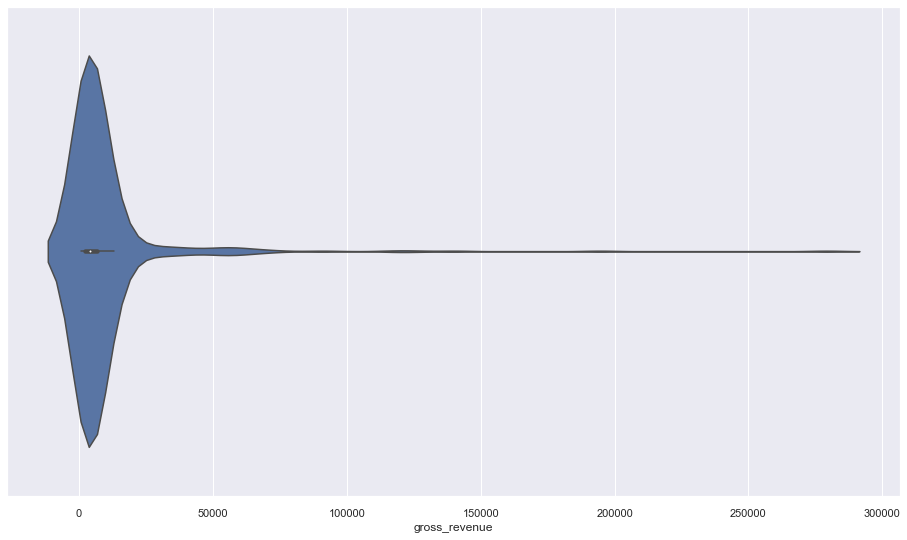

In [92]:
sns.violinplot(x = df10.loc[df10['cluster'] == 2, 'gross_revenue']);

# **Perguntas de negócios**

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?

2 Quantos clientes farão parte do grupo?


3 Quais as principais características desses clientes ?


4 Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?


5 Qual a expectativa de faturamento desse grupo para os próximos meses ?


6 Quais as condições para uma pessoa ser elegível ao Insiders ?


7 Quais as condições para uma pessoa ser removida do Insiders ?


8 Qual a garantia que o programa Insiders é melhor que o restante da base ?


9 Quais ações o time de marketing pode realizar para aumentar o faturamento?


### **1. Quem são as pessoas elegíveis para participar do programa de Insiders ?**

In [93]:
df10.loc[df10['cluster'] == 6, 'customer_id'].head()

9     16098
53    12662
58    12433
61    15605
88    13777
Name: customer_id, dtype: int32

### **2 Quantos clientes farão parte do grupo?**

In [94]:
df10.loc[df10['cluster'] == 6, 'customer_id'].size

130

### **3 Quais as principais características desses clientes insiders ?**

- Número de clientes: **376 clientes (13% do total de clientes)**
- Faturamento médio: **12713**
- Recência média: **18 dias**
- Média de produtos comprados: **401 produtos**
- Frequência de produtos comprados: **0.07 produtos/dia**
- Receita em média: **$12713.80**

### **4 Qual a porcentagem de contribuição do faturamento, vinda do Insiders?**

In [98]:
df_gmv_insiders = df10.loc[df10['cluster'] == 6, 'gross_revenue'].sum()
df_gmv_total = df10.loc[:, 'gross_revenue'].sum()

print('% GMV dos Insiders: {:.2f}%'.format(100* df_gmv_insiders/df_gmv_total))

% GMV dos Insiders: 7.63%


### **5 Qual a expectativa de faturamento desse grupo para os próximos meses ?**

#### Arima Model

In [1]:
print(11)

11
